## 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

#matplotlib 패키지 한글 깨짐 처리 시작
#한글 폰트(맑은 고딕) 적용 : 윈도우, 구글 콜랩
mpl.rc('font', family = "Malgun Gothic")
plt.rc('font', family = "Malgun Gothic")

#seaborn에서 한글 깨짐 해결
#minus 깨짐현상 방지
plt.rcParams['axes.unicode_minus'] = False

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.style.use('fivethirtyeight')

In [98]:
loan_prepared = pd.read_pickle("loan_prepared.pickle")
all_data = pd.read_pickle("all_data.pickle")

### *TODO

* 1. 데이터 불러오기
* 2. Train/Test Set 분리(언더샘플링)
* 3. Grid Search CV
    * 3-1. Lasso Grid Search
    * 3-2. Ridge Grid Search
    * 3-3. Elastic Grid Search
    * 3-4. No Regularlization Grid Search
* 4. 최종 모델 선택
* 5. 목적함수의 구현 
* 6. 최적 Threshold 도출
* 7. 평가

## 2. Train/Test Set 분리

In [7]:
y = loan_prepared['depvar']
X = loan_prepared.drop('depvar', axis=1)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, stratify=y, 
                                                    random_state=831)

In [19]:
y_train.value_counts(normalize=  True)

0    0.838205
1    0.161795
Name: depvar, dtype: float64

In [20]:
y_test.value_counts(normalize=  True)

0    0.838206
1    0.161794
Name: depvar, dtype: float64

In [25]:
from imblearn.under_sampling import *

#under sampling 으로 data 균형 맞춰주기
print('before undersampling counts of label 1 : {}'.format(sum(y_train == 1)))
print('before undersampling counts of label 0 : {}'.format(sum(y_train == 0)))

rus = RandomUnderSampler(random_state = 1234)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train.ravel())

print('after undersampling counts of label 1 : {}'.format(sum(y_train_res == 1)))
print('after undersampling counts of label 0 : {}'.format(sum(y_train_res == 0)))

before undersampling counts of label 1 : 141440
before undersampling counts of label 0 : 732752
after undersampling counts of label 1 : 141440
after undersampling counts of label 0 : 141440


## 3. Grid Search CV

### 3-1. Lasso Regularlization

In [26]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l1"], "solver": ['liblinear']}
lasso_reg=LogisticRegression()
lasso_reg_cv=GridSearchCV(lasso_reg, grid,cv=5)
lasso_reg_cv.fit(X_train_res,y_train_res)

print("best hpyerparameters: ",lasso_reg_cv.best_params_)
print("accuracy :",lasso_reg_cv.best_score_)

best hpyerparameters:  {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.8598204185520363


### 3-2. Ridge Regularlization

In [27]:
grid={"C":np.logspace(-3,3,7), "penalty":["l2"], "solver": ['newton-cg', 'liblinear', 'sag']}
ridge_reg=LogisticRegression()
ridge_reg_cv=GridSearchCV(ridge_reg, grid,cv=5)
ridge_reg_cv.fit(X_train_res,y_train_res)

print("best hpyerparameters: ",ridge_reg_cv.best_params_)
print("accuracy :",ridge_reg_cv.best_score_)

best hpyerparameters:  {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.859562358597285


### 3-3. ElasticNet Regularlization

In [29]:
grid={"C":np.logspace(-3,3,7), "penalty":["elasticnet"], "solver": ['saga'], "l1_ratio": [0.25, 0.5, 0.75]}
elastic_reg=LogisticRegression()
elastic_reg_cv=GridSearchCV(elastic_reg, grid,cv=5)
elastic_reg_cv.fit(X_train_res,y_train_res)

print("best hpyerparameters: ",elastic_reg_cv.best_params_)
print("accuracy :",elastic_reg_cv.best_score_)

best hpyerparameters:  {'C': 0.01, 'l1_ratio': 0.75, 'penalty': 'elasticnet', 'solver': 'saga'}
accuracy : 0.8594916572398189


### 3-4. No Regularlization

In [30]:
grid={"penalty":["none"], "solver": ['newton-cg', 'lbfgs', 'sag', 'saga']}
no_reg=LogisticRegression()
no_reg_cv=GridSearchCV(no_reg, grid,cv=5)
no_reg_cv.fit(X_train_res,y_train_res)

print("best hpyerparameters: ",no_reg_cv.best_params_)
print("accuracy :",no_reg_cv.best_score_)

best hpyerparameters:  {'penalty': 'none', 'solver': 'newton-cg'}
accuracy : 0.8593007635746606


In [42]:
result = {"Lasso": lasso_reg_cv.best_score_, "Ridge": ridge_reg_cv.best_score_, 
          "ElasticNet": elastic_reg_cv.best_score_, 
          "No_regularlization": no_reg_cv.best_score_}
result = pd.DataFrame(result, index=range(1))

,Lasso,Ridge,ElasticNet,No_regularlization
0,0.85982,0.859562,0.859492,0.859301


## 4. Best Model

위 Grid Search CV 결과 accuracy가 가장 높은 모델은 Lasso Regularlization의 경우 0.85982로 나타났습니다. 이를 기준으로 다시 모델을 훈련시키도록 하겠습니다.

In [46]:
model = LogisticRegression(fit_intercept = True, C= 0.001, penalty= 'l1', solver= 'liblinear')
model.fit(X_train_res, y_train_res)

LogisticRegression(C=0.001, penalty='l1', solver='liblinear')

In [57]:
coeff = pd.DataFrame(model.coef_.T, index=X_train.columns, columns=['coefficient'])

In [72]:
b = coeff.coefficient[(coeff.coefficient > 0) | (coeff.coefficient < 0)]
b

loan_amnt                0.316123
annual_inc              -0.182772
dti                      0.126551
inq_last_6mths           0.068090
revol_util              -0.025157
total_acc                0.127269
mths_since_rcnt_il      -0.040484
mths_since_recent_bc    -0.008552
last_fico_score         -2.806656
home_ownership_1        -0.040860
verification_status_2    0.000237
Name: coefficient, dtype: float64

Lasso Regularlization의 결과 회귀계수는 다음과 같습니다.

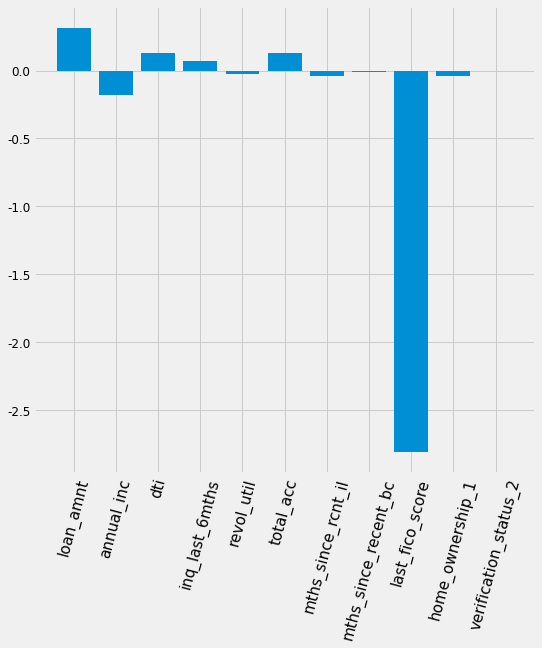

In [80]:
plt.figure(figsize=(8,8))
plt.bar(b.index, b.values)
plt.xticks(fontsize=15, rotation=75)
plt.show()

#### 회귀계수가 0이 아닌 특성의 의미:
* loan_amnt: 차입자가 신청한 대출금액 (부도 확률과 양의 상관성)
* annual_inc: 연간 소득 (부도 확률과 음의 상관성)
* dti: 소득대비 부채 비율 (부도 확률과 양의 상관성)
* inq_last_6mnths: 최근 6개월간 대출신청 문의 건수(자동차/주택담보 대출 제외) (부도 확률과 양의 상관성)
* revol_util: 총 이용가능한 신용 대비 사용중인 신용 (부도 확률과 양의 상관성)
* total_acc: 총 이용중인 신용계좌 개수 (부도 확률과 양의 상관성)
* mths_since_rcnt_il: 할부계정을 개설한 이후 경과 기간(월) (부도 확률과 음의 상관성)
* mths_since_recnet_bc: 은행계좌를 개설한 이후 경과 기간(월) (부도 확률과 불분명)
* last_fico_score: 가장 최근 FICO점수의 평균 (부도 확률과 음의 상관성)
* home_ownership_1: 주택 소유 유형이 모기지인지 여부 (부도 확률과 불분명)
* verification_status_2: 소득의 존재의 확인 여부 (부도 확률과 음의 상관성)  

#### 회귀계수 값이 0.01보다 큰 변수 중 해석상 상관관계와 회귀계수값이 일치하지 않는 변수:
* revol_util: -0.025157

해석상 이용가능한 신용 대비 사용중인 신용의 비율이 높을수록 부도 확률이 높을 것이라고 예측했지만 모델의 훈련 결과 해당 변수의 회귀계수가 음의 값으로 나왔습니다. 이에 대해, 오히려 적절한 신용을 이용하는 것이 신용 점수를 높이는 측면도 있고, 또 해당 회귀계수 값이 크지 않기 때문에 상식과 크게 어긋난다고 보기 어렵고 따라서 다중공선성의 문제를 의심할 충분한 근거가 될 수 없다고 판단하였습니다.

## 5. 목적함수의 구현

#### 목적함수에서 사후정보를 사용해도 되는지 여부
* 로지스틱 회귀분석의 과정과 목적함수의 최적화를 통한 최적 Threshold를 찾는 두 과정은 별개의 과정입니다.
* 로지스틱 회귀분석의 단계에선 사전 정보만을 사용하여 부도 여부를 예측하는 확률이 도출되었다면, 목적함수의 최적화 단계에선 그 동안의 축적된 데이터를 통해 최적의 임계 확률값을 찾는 과정입니다. 
* 따라서 목적함수는 비단 사전 정보에 국한될 필요 없이 회사의 목적에 맞게 자유롭게 설정될 수 있습니다.
* 저희 팀에서 설정한 목적함수는 다음과 같습니다.

#### 가중치 $w_{1}$: 
* 부도X예측 & 부도O인 경우, 못 받게된 금액 (`funded_amnt` * (1+`int_rate`) - `total_pymnt`)  

#### 가중치 $w_{2}$: 
* 부도O예측 & 부도X인 경우, 얻을 수 있었던 수익 기회비용 (`total_pymnt`+`total_rec_int`)  

#### 목적함수: 
$$Minimize \; Cost = \frac{w_{1}}{(w_{1} + w_{2})} \times (1-TPR)+ \frac{w_{2}}{(w_{1} + w_{2})} \times FPR $$

목적함수에 쓰일 `int_rate`, `funded_amnt`, `total_pymnt`, `total_rec_int`는 사후정보여서 Logistic 회귀 적합시 사용되지 않았으므로 여기서 추가해줍니다. 

In [100]:
def loss_function(roc_result, test):
    best = []
    for idx, value in roc_result.iterrows():
        # value[2]: threshold
        # 해당 threshold에 대해 부도 예측 1/0값을 val의 'logi_binary'에 저장

        test['logi_binary'] = np.array(np.where(test['pred_prob']>=value[2], 1, 0))

        #가중치(w_1): 부도X예측 & 부도O인 경우, 못 받게된 금액 (funded_amnt - total_pymnt)
        funded_amnt_1 = test.funded_amnt[(test.depvar==1)&(test.logi_binary==0)]
        int_rate_1 = test.int_rate[(test.depvar==1)&(test.logi_binary==0)]
        total_pymnt_1 = test.total_pymnt[(test.depvar==1)&(test.logi_binary==0)]

        w_1 = sum(funded_amnt_1 * (1+int_rate_1) - total_pymnt_1)

        #가중치(w_2): 부도O예측 & 부도X인 경우, 얻을 수 있었던 수익 기회비용 (total_pymnt)
        rec_int_2 = test.total_rec_int[(test.depvar==0)&(test.logi_binary==1)]
        w_2 = sum(rec_int_2)

        w_sum = w_1 + w_2

        #result: (w_1/w_sum) * (1-TPR) + (w_2/w_sum)* FPR 
        result = ((w_1/w_sum) * (1-value[1]) + ((w_2/w_sum) * value[0]))

        best.append(result)
    return best

## 6. 최적 Threshold의 도출

In [99]:
test = pd.merge(X_test, y_test, left_index=True, right_index=True)
test = pd.merge(test, all_data[['int_rate','funded_amnt','total_pymnt','total_rec_int']],
                left_index=True, right_index=True)

In [102]:
test['pred_prob'] = model.predict_proba(X_test)[:,1]

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


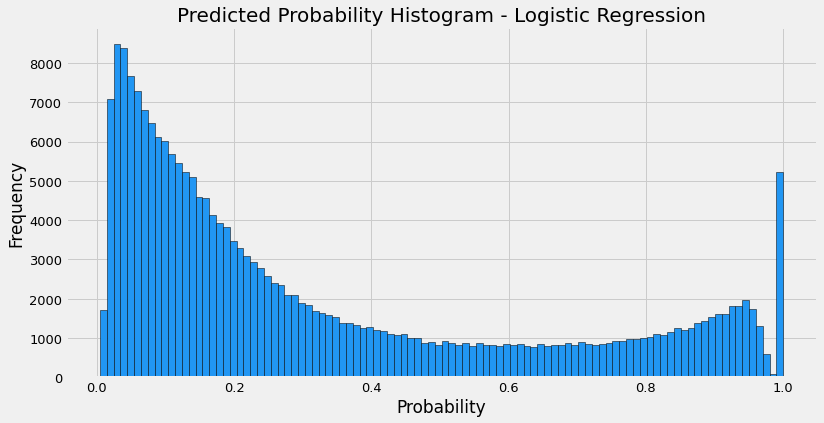

In [86]:
plt.figure(figsize=(12,6))
test.pred_prob.plot(kind='hist', bins=100, ec='black', color='#2196f3')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Probability', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.title('Predicted Probability Histogram - Logistic Regression', fontsize=20)
plt.show()

In [90]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

fpr, tpr, thresholds = roc_curve(test.depvar, test.pred_prob)
roc_auc = auc(fpr, tpr)

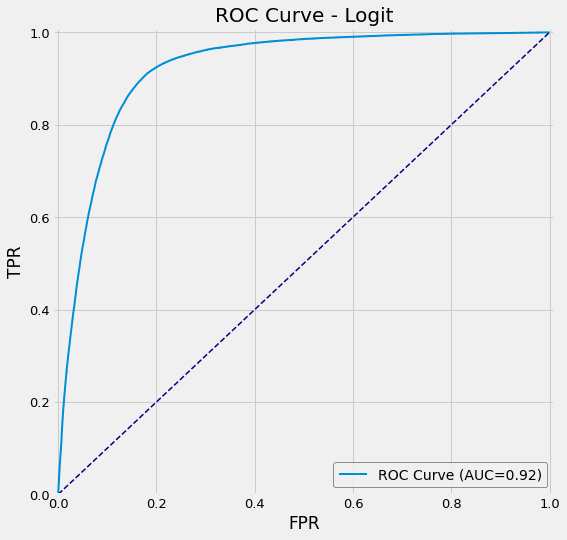

In [91]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC Curve (AUC=%.2f)' % roc_auc, lw=2)
plt.legend(loc='lower right', fontsize=14, frameon=True).get_frame().set_edgecolor('k')
plt.plot([0,1],[0,1], color='navy',linestyle='--', lw=1.5)
plt.xlim([-0.01,1.01])
plt.ylim([0,1.01])
plt.xlabel('FPR', fontsize=17)
plt.ylabel('TPR', fontsize=17)
plt.title('ROC Curve - Logit', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [92]:
roc_result = pd.DataFrame([fpr,tpr,thresholds], index=['fpr','tpr','thresholds']).T
roc_result

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.000005,0.000000,1.000000
2,0.000005,0.000198,1.000000
3,0.000011,0.000198,1.000000
4,0.000011,0.000255,0.999999
...,...,...,...
33863,0.997347,0.999943,0.011150
33864,0.997347,0.999972,0.011147
33865,0.997358,0.999972,0.011144
33866,0.997358,1.000000,0.011139


이제 목적함수를 돌리도록 하겠습니다. 돌리는 방식은 다음과 같습니다.  
roc_result에서 도출된 모든 가능한 thresholds에 대해 다음을 반복합니다.
* 특정 threshold값을 모델을 통해 예측한 부도확률과 비교하여 test셋의 부도 여부를 0 또는 1로 예측
* 예측된 부도 여부가 0인데 실제 부도가 1인 경우: w1의 가중치를 계산
* 예측된 부도 여부가 1인데 실제 부도가 0인 경우: w2의 가중치를 계산
* 계산된 가중치를 이용하여 각각 1-TPR과 FPR에 곱하여 Loss값을 계산
* 계산된 Loss값을 해당 threshold값과 대응
* 가장 Loss값이 작은 threshold가 최적의 threshold가 됨

In [103]:
best = loss_function(roc_result, test)

In [104]:
roc_result['best'] = best
roc_result

,fpr,tpr,thresholds,best
0,0.000000,0.000000,2.000000,1.000000
1,0.000005,0.000000,1.000000,0.999964
2,0.000005,0.000198,1.000000,0.999766
3,0.000011,0.000198,1.000000,0.999728
4,0.000011,0.000255,0.999999,0.999672
...,...,...,...,...
33863,0.997347,0.999943,0.011150,0.997296
33864,0.997347,0.999972,0.011147,0.997320
33865,0.997358,0.999972,0.011144,0.997330
33866,0.997358,1.000000,0.011139,0.997358


가장 작은 Loss값에 해당하는 Threshold와 그 때의 Loss값은 다음과 같습니다.

In [105]:
min_loss = min(best)
min_loss_index = roc_result.best.idxmin()
optimal_threshold = roc_result.thresholds[roc_result.best.idxmin()]
optimal_index = roc_result.index[roc_result.thresholds==optimal_threshold]

print('Optimal Threshold:', optimal_threshold)
print('Minimized Loss:', min_loss)

Optimal Threshold: 0.5050177283247143
Minimized Loss: 0.14023025912430828


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


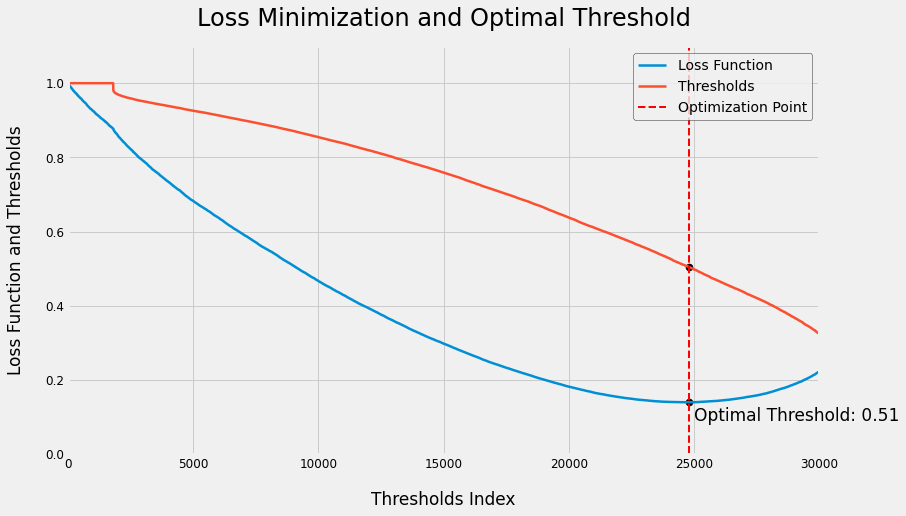

In [106]:
plt.figure(figsize=(12,7))
plt.plot(roc_result.index[1:], roc_result.best[1:], label='Loss Function', lw=2.5)
plt.plot(roc_result.index[1:], roc_result.thresholds[1:], label='Thresholds', lw=2.5)
plt.scatter(optimal_index, optimal_threshold, s=50, c='k')
plt.scatter(min_loss_index, min_loss, s=50, c='k')
plt.plot([min_loss_index, min_loss_index], [-100, 100], c='red', linestyle='--', label='Optimization Point', lw=2)
plt.text(x=roc_result.best.idxmin()+200, y=min_loss-0.05, s='Optimal Threshold: {:.2f}'.format(optimal_threshold), fontsize=17)
plt.ylim([0,1.1])
plt.xlim([0,30000])
plt.xlabel('Thresholds Index', fontsize=17, labelpad=20)
# plt.tick_params(axis='x', direction='in', length=3, pad=6, labelsize=14, labelcolor='green', top=True)
plt.ylabel('Loss Function and Thresholds', fontsize=17, labelpad=20)
plt.title('Loss Minimization and Optimal Threshold', fontsize=24, pad=20)
plt.legend(loc='upper right',fontsize=14, frameon=True).get_frame().set_edgecolor('k')
plt.grid(b=True)
plt.style.use('fivethirtyeight')
plt.show()

## 7. 성능 평가

In [108]:
test['logi_binary'] = np.array(np.where(test['pred_prob']>=optimal_threshold, 1, 0))

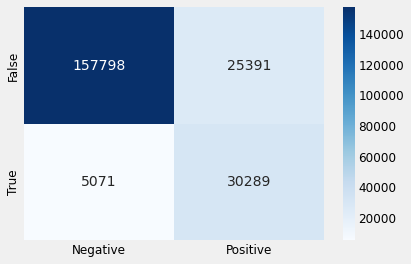

In [112]:
test_dt_con = confusion_matrix(test.depvar, test.logi_binary)
test_df_con = pd.DataFrame(test_dt_con, index = ['False', 'True'], columns = ['Negative', 'Positive'])
sns.heatmap(test_df_con, annot = True, fmt = 'd', cmap = 'Blues', annot_kws = {'size' : 14})
plt.style.use('default')

In [115]:
tn, fp, fn, tp = confusion_matrix(test.depvar, test.logi_binary).ravel()
(tn, fp, fn, tp)

(157798, 25391, 5071, 30289)

In [116]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2/((1/precision)+(1/recall))
print('TPR:', round(recall, 3))
print('FPR:', round(fp/(tn+fp), 3))
print('Precision', round(tp/(fp+tp),3))
print('Accuracy:', round((tn+tp)/(tn+fp+fn+tp), 3))
print('f1 Score:', round(f1_score, 3))

TPR: 0.857
FPR: 0.139
Precision 0.544
Accuracy: 0.861
f1 Score: 0.665
